In [100]:
# LSTM Autoencoder for Multivariate Anomaly Detection

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [102]:
battery_temp = pd.read_csv('BatteryTemperature.csv', parse_dates=[0], index_col=0, names=["timestamp", "battery_temp"])
bus_voltage = pd.read_csv('BusVoltage.csv', parse_dates=[0], index_col=0, names=["timestamp", "bus_voltage"])
bus_current = pd.read_csv('TotalBusCurrent.csv', parse_dates=[0], index_col=0, names=["timestamp", "bus_current"])
wheel_rpm = pd.read_csv('WheelRPM.csv', parse_dates=[0], index_col=0, names=["timestamp", "wheel_rpm"])
wheel_temp = pd.read_csv('WheelTemperature.csv', parse_dates=[0], index_col=0, names=["timestamp", "wheel_temp"])


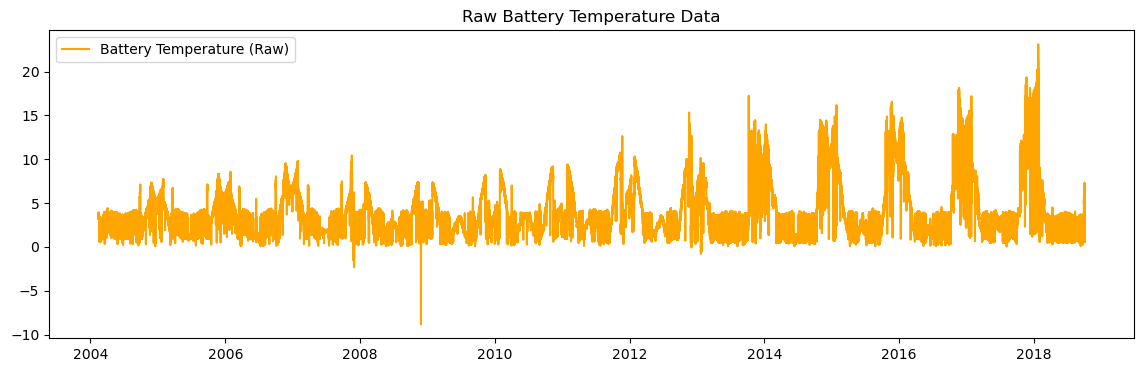

In [103]:
plt.figure(figsize=(14,4))
plt.plot(battery_temp.index, battery_temp['battery_temp'], label='Battery Temperature (Raw)', color='orange')
plt.title('Raw Battery Temperature Data')
plt.legend()
plt.show()

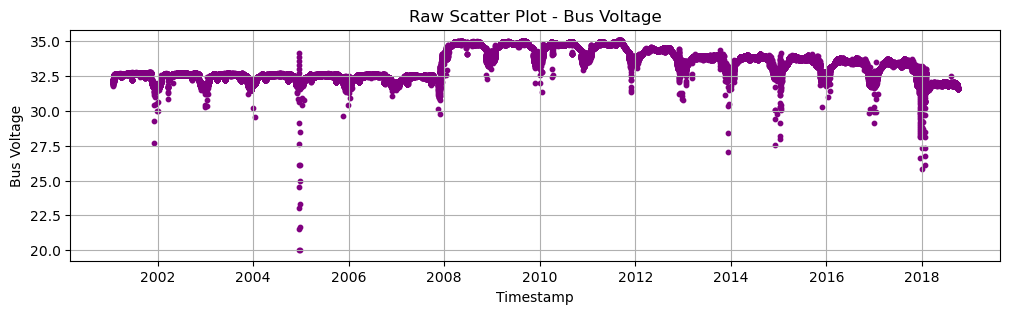

In [106]:
plt.figure(figsize=(12,3))
plt.scatter(bus_voltage.index, bus_voltage['bus_voltage'], color='purple', s=10)  # 's' is size of dots
plt.title('Raw Scatter Plot - Bus Voltage')
plt.xlabel('Timestamp')
plt.ylabel('Bus Voltage')
plt.grid(True)
plt.show()

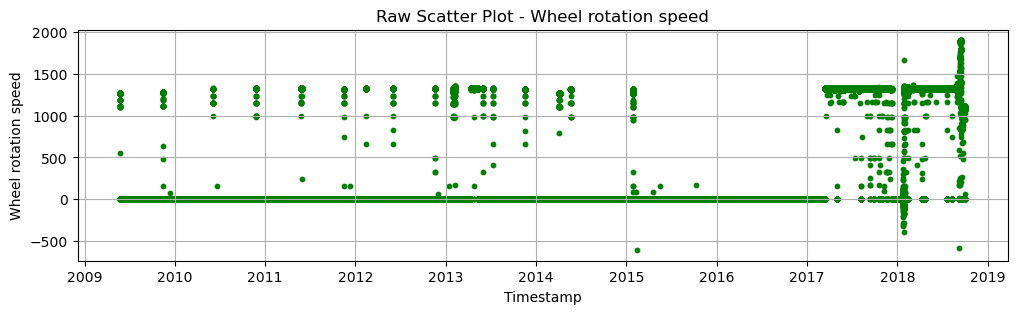

In [108]:
plt.figure(figsize=(12,3))
plt.scatter(wheel_rpm.index, wheel_rpm['wheel_rpm'], color='green', s=10)  # 's' is size of dots
plt.title('Raw Scatter Plot - Wheel rotation speed')
plt.xlabel('Timestamp')
plt.ylabel('Wheel rotation speed')
plt.grid(True)
plt.show()

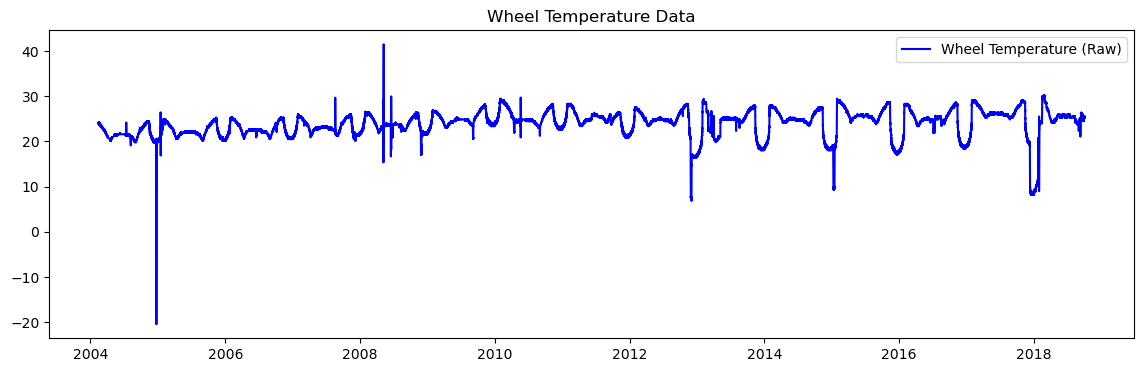

In [109]:
plt.figure(figsize=(14,4))
plt.plot(wheel_temp.index, wheel_temp['wheel_temp'], label='Wheel Temperature (Raw)', color='blue')
plt.title('Wheel Temperature Data')
plt.legend()
plt.show()

In [110]:
battery_temp = battery_temp.resample('1H').mean()
bus_voltage = bus_voltage.resample('3H').mean()
bus_current = bus_current.resample('1D').mean()
wheel_rpm = wheel_rpm.resample('5min').mean()
wheel_temp = wheel_temp.resample('10min').mean()

C:\Users\adith\AppData\Local\Temp\ipykernel_26932\3832845727.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  battery_temp = battery_temp.resample('1H').mean()
C:\Users\adith\AppData\Local\Temp\ipykernel_26932\3832845727.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bus_voltage = bus_voltage.resample('3H').mean()


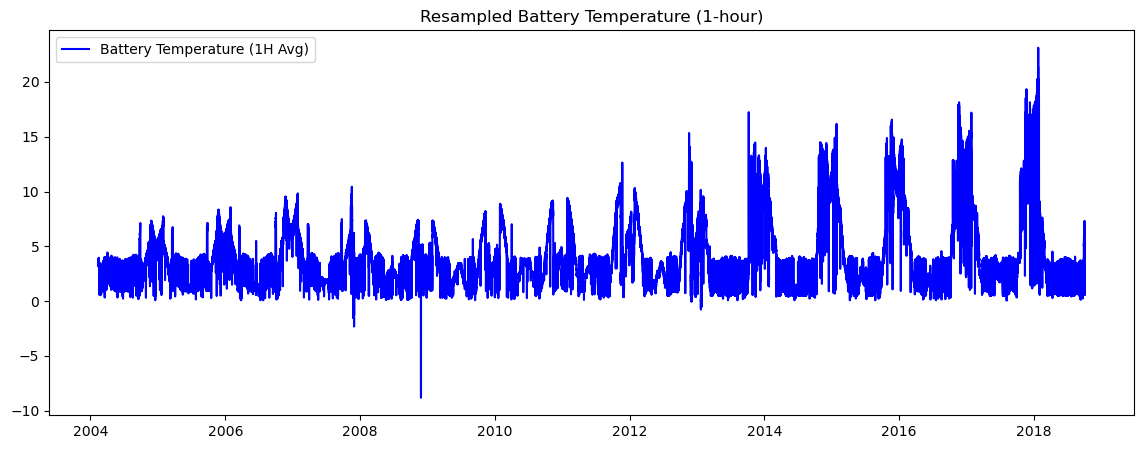

In [112]:
plt.figure(figsize=(14,5))
plt.plot(battery_temp.index, battery_temp['battery_temp'], label='Battery Temperature (1H Avg)', color='blue')
plt.title('Resampled Battery Temperature (1-hour)')
plt.legend()
plt.show()

In [116]:
full_data = battery_temp.join([bus_voltage, bus_current, wheel_rpm, wheel_temp], how='outer')
full_data = full_data.interpolate().dropna()

In [118]:
full_data

,battery_temp,bus_voltage,bus_current,wheel_rpm,wheel_temp
timestamp,,,,,
2009-05-22 22:30:00,1.873130,34.858240,11.264086,1266.527199,24.486791
2009-05-22 22:35:00,1.883519,34.858383,11.264183,1267.382818,24.486791
2009-05-22 22:40:00,1.893909,34.858525,11.264280,1267.260905,24.486791
2009-05-22 22:45:00,1.904298,34.858668,11.264377,1267.305787,24.486791
2009-05-22 22:50:00,1.914687,34.858811,11.264474,1267.859010,24.486791
...,...,...,...,...,...
2018-10-02 23:10:00,0.593578,31.536154,5.510878,1031.661722,25.229268
2018-10-02 23:20:00,0.593578,31.536154,5.510878,1031.661722,25.229268
2018-10-02 23:30:00,0.593578,31.536154,5.510878,1031.661722,25.229268


In [120]:

# Step 1: Initialize the anomaly column if it doesn't exist.
# This ensures all data points start as 'normal' (0).
if 'is_anomaly' not in full_data.columns:
    full_data['is_anomaly'] = 0

# Step 2: Define the list of numerical columns to check for anomalies.
columns_to_check = ['battery_temp', 'bus_voltage', 'bus_current', 'wheel_rpm', 'wheel_temp']

# Step 3: Set the threshold for detection.
# A common choice is 3, meaning data points more than 3 standard deviations
# from the mean will be considered anomalies. You can adjust this value.
threshold = 3

# Step 4: Iterate through each column, detect, and label anomalies.
print("--- Searching for Anomalies ---")
for col in columns_to_check:
    # Calculate the mean and standard deviation for the current column
    mean = full_data[col].mean()
    std_dev = full_data[col].std()

    # Identify the rows where the column's value is an outlier
    outliers = full_data[np.abs(full_data[col] - mean) > threshold * std_dev]

    if not outliers.empty:
        print(f"Found {len(outliers)} potential anomalies in column '{col}'.")
        # Label these rows as anomalies (1) in the 'is_anomaly' column
        full_data.loc[outliers.index, 'is_anomaly'] = 1
    else:
        print(f"No anomalies found in column '{col}' with the current threshold.")


# Step 5: Display the final count of normal vs. anomalous data points.
print("\n--- Final Anomaly Report ---")
print(full_data['is_anomaly'].value_counts())

# You can also view the rows that were flagged as anomalies
# print("\n--- Details of Flagged Anomalies ---")
# print(full_data[full_data['is_anomaly'] == 1])

--- Searching for Anomalies ---
Found 10200 potential anomalies in column 'battery_temp'.
Found 2856 potential anomalies in column 'bus_voltage'.
Found 22106 potential anomalies in column 'bus_current'.
Found 811 potential anomalies in column 'wheel_rpm'.
Found 17173 potential anomalies in column 'wheel_temp'.

--- Final Anomaly Report ---
is_anomaly
0    954672
1     30273
Name: count, dtype: int64


In [122]:
# Make sure to separate the labels ('is_anomaly') before scaling
labels = full_data['is_anomaly']
features_df = full_data.drop('is_anomaly', axis=1)

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features_df)


In [124]:
full_data

,battery_temp,bus_voltage,bus_current,wheel_rpm,wheel_temp,is_anomaly
timestamp,,,,,,
2009-05-22 22:30:00,1.873130,34.858240,11.264086,1266.527199,24.486791,0
2009-05-22 22:35:00,1.883519,34.858383,11.264183,1267.382818,24.486791,0
2009-05-22 22:40:00,1.893909,34.858525,11.264280,1267.260905,24.486791,0
2009-05-22 22:45:00,1.904298,34.858668,11.264377,1267.305787,24.486791,0
2009-05-22 22:50:00,1.914687,34.858811,11.264474,1267.859010,24.486791,0
...,...,...,...,...,...,...
2018-10-02 23:10:00,0.593578,31.536154,5.510878,1031.661722,25.229268,0
2018-10-02 23:20:00,0.593578,31.536154,5.510878,1031.661722,25.229268,0
2018-10-02 23:30:00,0.593578,31.536154,5.510878,1031.661722,25.229268,0


In [126]:
labels

timestamp
2009-05-22 22:30:00    0
2009-05-22 22:35:00    0
2009-05-22 22:40:00    0
2009-05-22 22:45:00    0
2009-05-22 22:50:00    0
                      ..
2018-10-02 23:10:00    0
2018-10-02 23:20:00    0
2018-10-02 23:30:00    0
2018-10-02 23:40:00    0
2018-10-02 23:50:00    0
Name: is_anomaly, Length: 984945, dtype: int64

In [128]:
# STEP 2: Create sequences for LSTM input
def create_sequences(data, labels, seq_length):
    xs, y = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        xs.append(x)
        y.append(labels.iloc[i + seq_length])
    return np.array(xs), np.array(y)


In [130]:
SEQ_LEN = 30  # Window size for time-series sequence
X, y = create_sequences(scaled_data, labels, SEQ_LEN)

In [131]:
# Step 4: Check the shape of your new 3D array
print("--- Data Shape Verification ---")
print("Original DataFrame shape:", full_data.shape)
print("Shape of 3D features (X):", X.shape)
print("Shape of labels (y):", y.shape)
print(f"Number of samples in X: {X.shape[0]}")
print(f"Number of samples in y: {y.shape[0]} <-- These should match!")

--- Data Shape Verification ---
Original DataFrame shape: (984945, 6)
Shape of 3D features (X): (984915, 30, 5)
Shape of labels (y): (984915,)
Number of samples in X: 984915
Number of samples in y: 984915 <-- These should match!


In [134]:
train_split_fraction = 0.8

# 2. Calculate the split index
split_index = int(len(X) * train_split_fraction)

# 3. Perform the chronological split
X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]

In [136]:
# 4. Verify the shapes of your new sets
print("--- Data Split Verification ---")
print("Total samples:", len(X))
print("\n--- Training Set ---")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("\n--- Testing Set ---")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

--- Data Split Verification ---
Total samples: 984915

--- Training Set ---
X_train shape: (787932, 30, 5)
y_train shape: (787932,)

--- Testing Set ---
X_test shape: (196983, 30, 5)
y_test shape: (196983,)


In [140]:
# STEP 3: Build LSTM Autoencoder
n_features = X_train.shape[2]
input_layer = Input(shape=(SEQ_LEN, n_features))

In [142]:
# Encoder
encoder = LSTM(128, activation='relu', return_sequences=False)(input_layer)
bottleneck = RepeatVector(SEQ_LEN)(encoder)

# Decoder
decoder = LSTM(128, activation='relu', return_sequences=True)(bottleneck)

# Output layer to match original feature size
output = TimeDistributed(Dense(n_features))(decoder)

autoencoder = Model(inputs=input_layer, outputs=output)
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 30, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 128)                 │          68,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_2 (RepeatVector)       │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 30, 5)               │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 200,837 (784.52 KB)

 Trainable params: 200,837 (784.52 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# STEP 4: Train the model
history = autoencoder.fit(
    X_train, X_train,
    epochs=25,
    batch_size=32,
    validation_data = (X_test, X_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)],
    shuffle=False
)


Epoch 1/25
24623/24623 ━━━━━━━━━━━━━━━━━━━━ 585s 24ms/step - loss: 0.0527 - val_loss: 0.7530
Epoch 2/25
24623/24623 ━━━━━━━━━━━━━━━━━━━━ 564s 23ms/step - loss: 0.0365 - val_loss: 0.6118
Epoch 3/25
24623/24623 ━━━━━━━━━━━━━━━━━━━━ 566s 23ms/step - loss: 0.0290 - val_loss: 0.5549
Epoch 4/25
24623/24623 ━━━━━━━━━━━━━━━━━━━━ 570s 23ms/step - loss: 0.0243 - val_loss: 0.5327
Epoch 5/25
24623/24623 ━━━━━━━━━━━━━━━━━━━━ 573s 23ms/step - loss: 0.0216 - val_loss: 0.3692
Epoch 6/25
24623/24623 ━━━━━━━━━━━━━━━━━━━━ 572s 23ms/step - loss: 0.0196 - val_loss: 0.7116
Epoch 7/25
24623/24623 ━━━━━━━━━━━━━━━━━━━━ 584s 24ms/step - loss: 0.0182 - val_loss: 0.4279
Epoch 8/25
24623/24623 ━━━━━━━━━━━━━━━━━━━━ 588s 24ms/step - loss: 0.0321 - val_loss: 2.7781
Epoch 9/25
24623/24623 ━━━━━━━━━━━━━━━━━━━━ 591s 24ms/step - loss: 0.0421 - val_loss: 0.7796
Epoch 10/25
24623/24623 ━━━━━━━━━━━━━━━━━━━━ 594s 24ms/step - loss: 22.4144 - val_loss: 8615.3330


In [150]:
# 1. Get the model's reconstructions of the test data
# The model will try to recreate the input sequences it was given.
print("--- Generating reconstructions from test data... ---")
reconstruction = autoencoder.predict(X_test)

# 2. Calculate the reconstruction error (MAE) CORRECTLY
test_mae = np.mean(np.abs(reconstruction - X_test), axis=(1, 2))


--- Generating reconstructions from test data... ---
6156/6156 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step


In [152]:
print("--- Calculating reconstruction error... ---")
print(f"Shape of calculated MAE array: {test_mae.shape}")

--- Calculating reconstruction error... ---
Shape of calculated MAE array: (196983,)


In [154]:
print("--- Calculating reconstruction error... ---")

# 3. Determine the anomaly threshold
threshold = np.percentile(test_mae, 95)
print(f"Anomaly threshold set to: {threshold:.4f} (95th percentile of errors)")

--- Calculating reconstruction error... ---
Anomaly threshold set to: 2.7204 (95th percentile of errors)


In [156]:
# 4. Classify sequences as anomaly (1) or normal (0)
# If a sequence's reconstruction error is above the threshold, we label it an anomaly.
y_pred = (test_mae > threshold).astype(int)

In [158]:
# --- Add this code right before your classification_report call ---
# 5. Add a final safety check before the report
if y_test.shape != y_pred.shape:
    print("FATAL ERROR: y_test and y_pred still have mismatched shapes!")
    print(f"y_test shape: {y_test.shape}")
    print(f"y_pred shape: {y_pred.shape}")
else:
    # 6. Generate and print the classification report
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'Anomaly (1)']))


--- Classification Report ---
              precision    recall  f1-score   support

  Normal (0)       0.94      1.00      0.97    176089
 Anomaly (1)       1.00      0.47      0.64     20894

    accuracy                           0.94    196983
   macro avg       0.97      0.74      0.81    196983
weighted avg       0.95      0.94      0.93    196983




--- Confusion Matrix ---


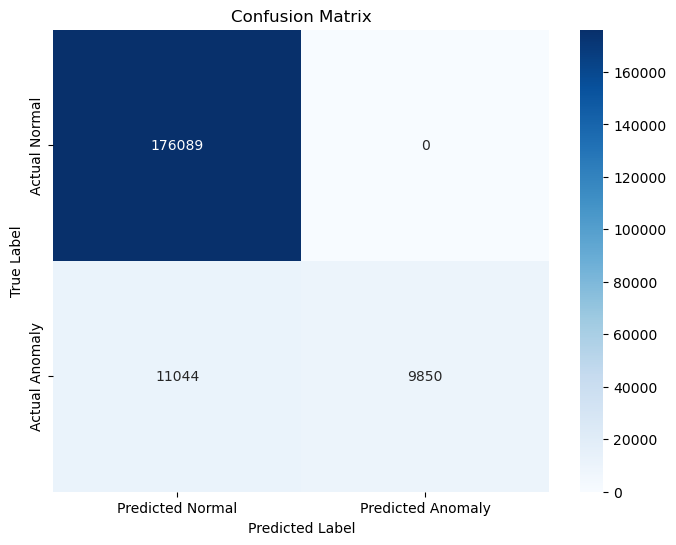

In [193]:
 # 7. Visualize the Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Anomaly'],
            yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

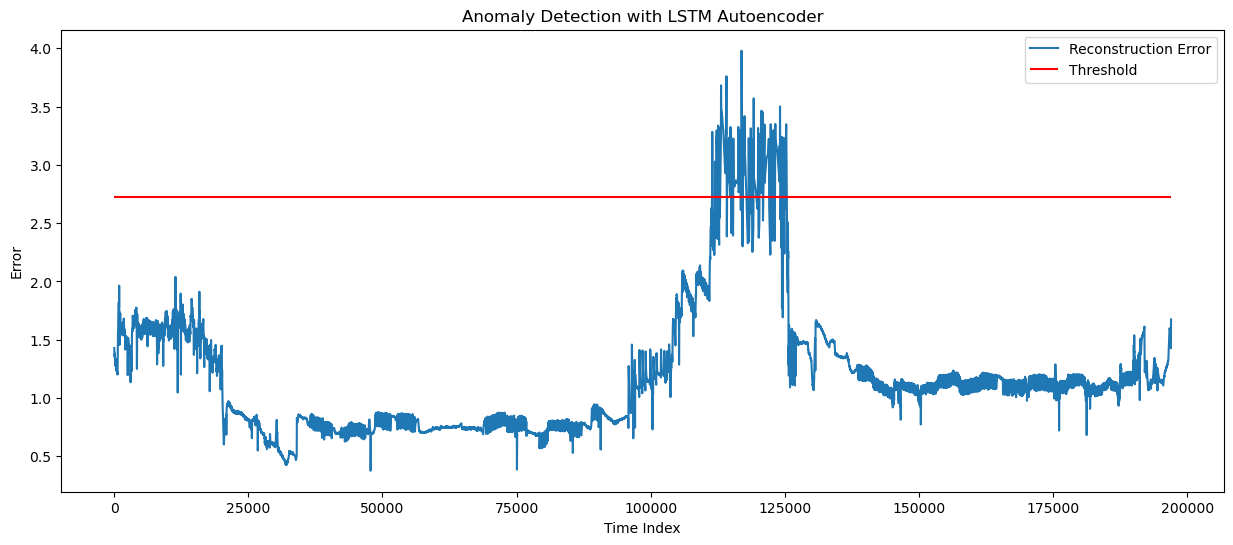

In [172]:
# Plot the reconstruction error
plt.figure(figsize=(15, 6))
plt.plot(test_mae, label='Reconstruction Error')
plt.hlines(threshold, 0, len(test_mae), colors='red', label='Threshold')
plt.title('Anomaly Detection with LSTM Autoencoder')
plt.xlabel('Time Index')
plt.ylabel('Error')
plt.legend()
plt.show()


In [185]:
# First, ensure that the boolean mask and the array have the same length
if len(test_mae) != len(full_data.index[SEQ_LEN:]):
    # Option 1: Truncate the longer array to match the shorter one
    min_length = min(len(test_mae), len(full_data.index[SEQ_LEN:]))
    anomalies = test_mae[:min_length] > threshold
    anomaly_timestamps = full_data.index[SEQ_LEN:][:min_length][anomalies]
else:
    # Option 2: If they already have the same length, proceed as intended
    anomalies = test_mae > threshold
    anomaly_timestamps = full_data.index[SEQ_LEN:][anomalies]

print("Anomalies detected at:")
print(anomaly_timestamps)


Anomalies detected at:
DatetimeIndex(['2010-06-13 22:40:00', '2010-06-13 22:45:00',
               '2010-06-13 22:50:00', '2010-06-13 22:55:00',
               '2010-06-13 23:00:00', '2010-06-13 23:05:00',
               '2010-06-13 23:10:00', '2010-06-13 23:15:00',
               '2010-06-13 23:20:00', '2010-06-13 23:25:00',
               ...
               '2010-08-01 07:15:00', '2010-08-01 07:20:00',
               '2010-08-01 07:25:00', '2010-08-01 07:30:00',
               '2010-08-01 07:35:00', '2010-08-01 07:40:00',
               '2010-08-01 07:45:00', '2010-08-01 07:50:00',
               '2010-08-01 07:55:00', '2010-08-01 08:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=9850, freq=None)


In [187]:
# Create and save anomaly scores
anomaly_scores = pd.Series(recon_error, index=full_data.index[SEQ_LEN:], name="anomaly_score")
anomaly_scores.to_csv("anomaly_scores.csv")
print("Anomaly scores saved to 'anomaly_scores.csv'")


Anomaly scores saved to 'anomaly_scores.csv'


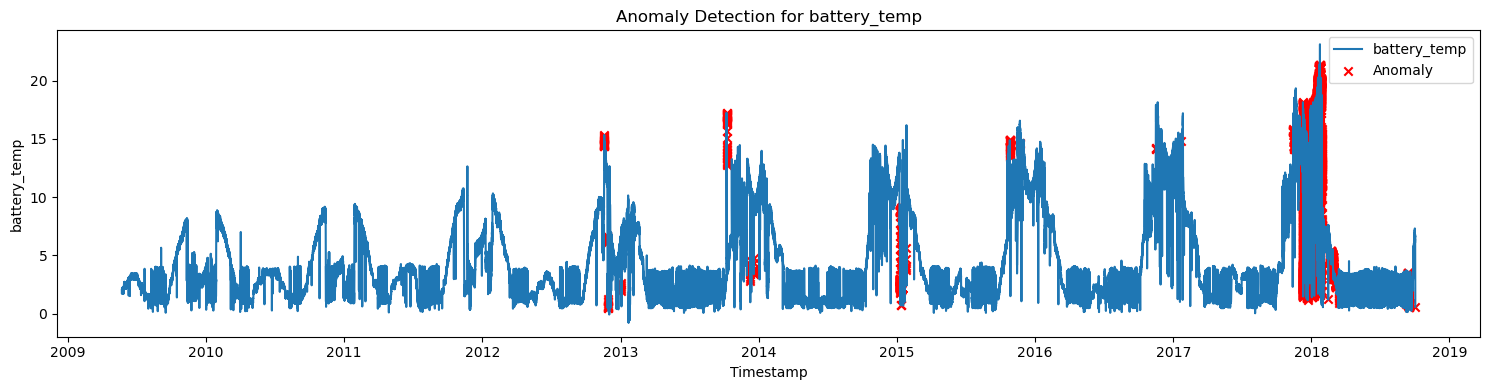

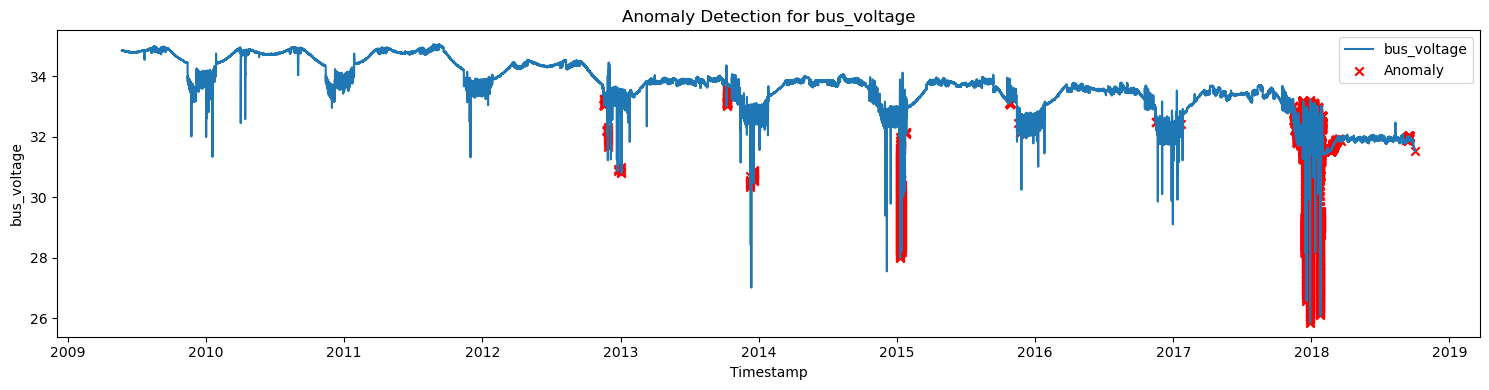

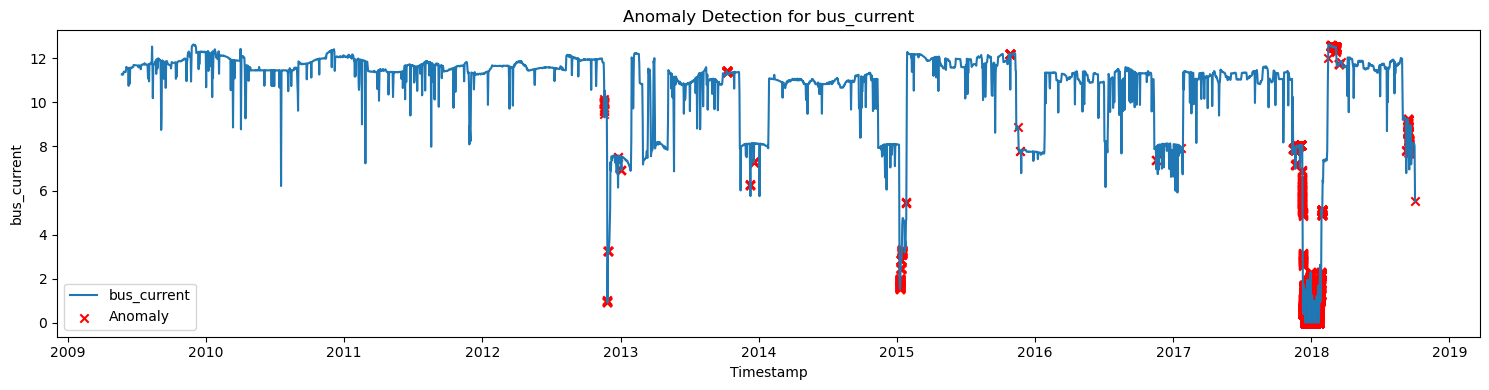

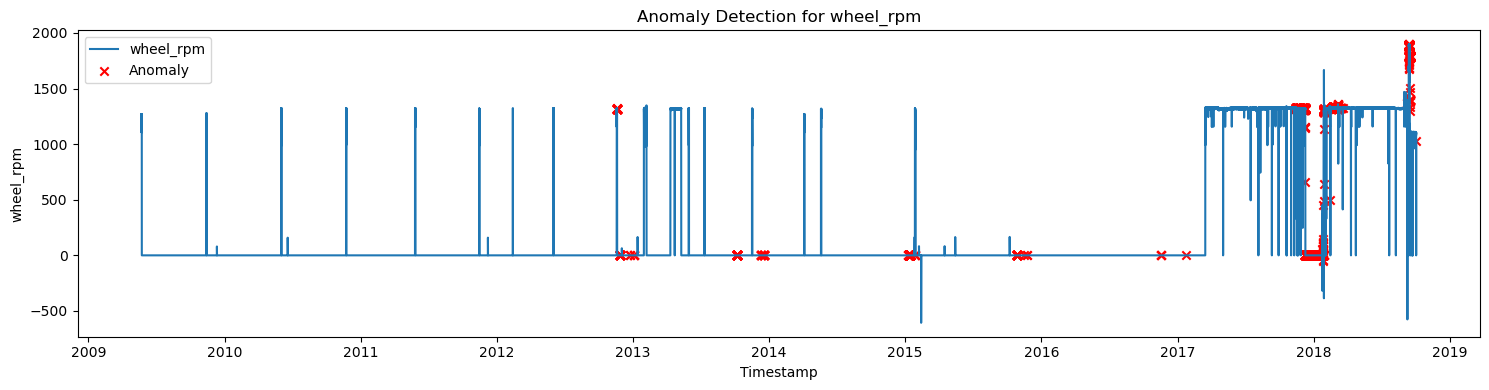

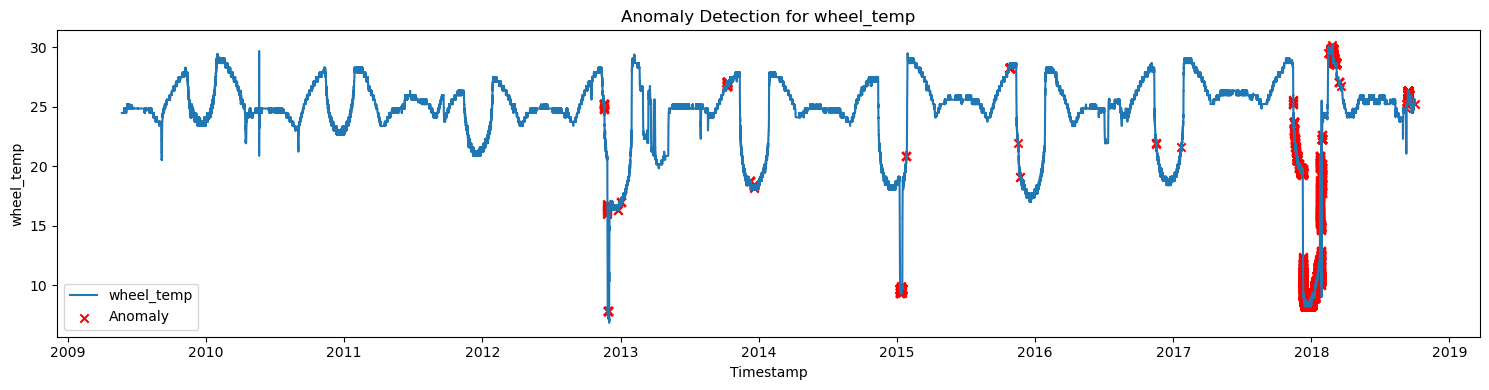

In [191]:
# Generate binary anomaly labels
anomaly_flags = (anomaly_scores > threshold).astype(int)

# Get the timestamp-aligned data post sequence creation
aligned_data = features_df.iloc[SEQ_LEN:]

# Plot anomaly detection for each feature
for column in aligned_data.columns:
    plt.figure(figsize=(15, 4))
    plt.plot(aligned_data.index, aligned_data[column], label=column)
    plt.scatter(aligned_data.index[anomaly_flags == 1],
                aligned_data[column][anomaly_flags == 1],
                color='red', marker='x', label='Anomaly')
    plt.title(f"Anomaly Detection for {column}")
    plt.xlabel("Timestamp")
    plt.ylabel(column)
    plt.legend()
    plt.tight_layout()
    plt.show()